In [1]:
import numpy as np
import wisps
import wisps.simulations as wispsim
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm 
import pandas as pd
import matplotlib as mpl
import wisps.simulations.effective_numbers as eff
import astropy.coordinates as astrocoord
from wisps import drop_nan
import seaborn as sns
%matplotlib inline
import splat



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




###Step by step checking

1. Distances before and after cuts 

In [2]:
#wispsim.make_pointings()

In [3]:
wispsim.MAG_LIMITS['mag_limits_imaging']

{'wisps': {'F110': (poly1d([ 1.20489888, 18.31086895]), 0.2844013697684069),
  'F140': (poly1d([ 1.49122797, 17.14118556]), 0.29135610105223764),
  'F160': (poly1d([ 1.36561328, 17.37352631]), 0.22849282117355352)}}

In [4]:
#cands=pd.read_pickle(wisps.LIBRARIES+'/real_ucds.pkl')

In [5]:
cmap_teff=sns.diverging_palette(100, 300, s=80, l=55, n=19, as_cmap=True)

In [6]:
#older_pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_corrected.pkl')
#older_pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_unccorrected.pkl')

pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')
#pnts140=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf140.pkl')
#pnts160=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf160.pkl')

In [7]:
len(pnts)

532

In [8]:

#nl

In [9]:
from matplotlib.colors import Normalize


In [10]:
from scipy import integrate

In [11]:
volume_fx=np.vectorize(wispsim.custom_volume)

In [12]:
import seaborn as sns
import matplotlib
#cmap= sns.color_palette("coolwarm", 8, as_cmap=True)
cmap=matplotlib.cm.get_cmap('coolwarm')
cnorm=Normalize(wispsim.HS[0]/100, (wispsim.HS[-1])/100)

In [13]:
mag_f=pd.DataFrame.from_records([x.mag_limits for x in pnts])

In [14]:
#wcands=cands[cands.grism_id.str.lower().str.startswith('par')]
#hcands=cands[~cands.grism_id.str.lower().str.startswith('par')]

In [15]:
import numba
@numba.jit
def get_kde(r, z):
    kde=wisps.kernel_density([r, z])
    dens=kde.pdf([r, z])
    return dens

In [16]:
corr_pols=wisps.POLYNOMIAL_RELATIONS['mag_limit_corrections'] 

In [17]:
wispsim.MAG_LIMITS['ncutoff']

50

In [18]:
x=pnts[0]

In [19]:
#

In [20]:
def less_than_fifty(row):
    ser={'lF110':False, 'lF140':False, 'lF160':False}
    
    if row.nF110 <wispsim.MAG_LIMITS['ncutoff']:
        ser['lF110']=True
    if row.nF140 <wispsim.MAG_LIMITS['ncutoff']:
        ser['lF140']=True
    if row.nF160 <wispsim.MAG_LIMITS['ncutoff']:
        ser['lF160']=True
    return pd.Series(ser)

maglimits=pd.DataFrame([x.mag_limits for x in pnts])
maglimits['imexp']=[x.imag_exptime for x in pnts]
maglimits['pointing']=[x.name for x in pnts]
maglimits['survey']=[x.survey for x in pnts]
maglimits['specexp']=[x.exposure_time for x in pnts]

nsrcs=pd.DataFrame([x.number_of_sources  for x in pnts])
number_of_sources=nsrcs.rename(columns={'F140': 'nF140', 'F160': 'nF160', 'F110':'nF110'})
less_than_df=number_of_sources.apply(less_than_fifty, axis=1)
number_of_sources['pointing']=[x.name for x in pnts]
number_of_sources=number_of_sources.join(less_than_df)
mag_lts_df=maglimits.merge(number_of_sources, on='pointing')


In [21]:
mag_lts_df.imexp.median(), mag_lts_df.imexp.std()

(812.0, 589.792720003026)

In [22]:
wispmglts=mag_lts_df[mag_lts_df.survey=='wisps']
hst3dpmglts=mag_lts_df[mag_lts_df.survey!='wisps']

In [23]:
#hst3dpmglts

In [24]:
wispsim.MAG_LIMITS['mag_limits_imaging']

{'wisps': {'F110': (poly1d([ 1.20489888, 18.31086895]), 0.2844013697684069),
  'F140': (poly1d([ 1.49122797, 17.14118556]), 0.29135610105223764),
  'F160': (poly1d([ 1.36561328, 17.37352631]), 0.22849282117355352)}}

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


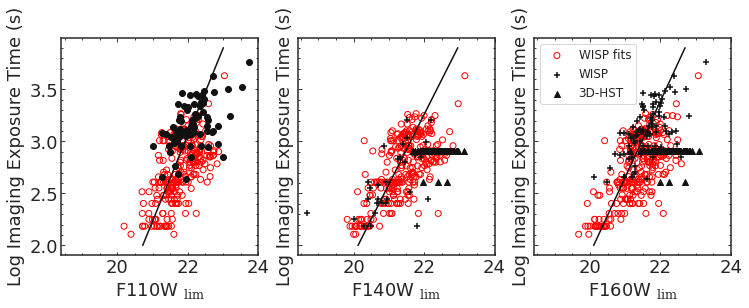

In [25]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4),  sharex=True, sharey=True)

ax[0].scatter(wispmglts['F110'][wispmglts.lF110.apply(bool)],
              np.log10(wispmglts.imexp)[wispmglts.lF110.apply(bool)], 
         facecolors='none', edgecolors='r', marker='o')
ax[0].scatter(wispmglts['F110'][~wispmglts.lF110.apply(bool)],
              np.log10(wispmglts.imexp)[~wispmglts.lF110.apply(bool)], 
         marker='o', color='#111111')

ax[0].plot(wispsim.MAG_LIMITS['mag_limits_imaging']['wisps']['F110'][0](np.arange(2, 4, 0.1)),
              np.arange(2, 4, 0.1), color='#111111')

ax[1].scatter(wispmglts['F140'][wispmglts.lF140.apply(bool)],
              np.log10(wispmglts.imexp)[wispmglts.lF140.apply(bool)], 
           facecolors='none', edgecolors='r', marker='o')
ax[1].scatter(wispmglts['F140'][~wispmglts.lF140.apply(bool)],
              np.log10(wispmglts.imexp)[~wispmglts.lF140.apply(bool)], 
           marker='+', color='#111111')
ax[1].plot(wispsim.MAG_LIMITS['mag_limits_imaging']['wisps']['F140'][0](np.arange(2, 4, 0.1)),
              np.arange(2, 4, 0.1),  color='#111111')
ax[1].scatter(hst3dpmglts['F140'], np.log10(hst3dpmglts.imexp),  
              marker='^', color='#111111')

#ax[1][1].scatter(hst3dpmglts['F140'], np.log10(hst3dpmglts.imexp), 
#           c=hst3dpmglts.lF140.apply(int), cmap='coolwarm', marker='o')

ax[2].scatter(wispmglts['F160'][wispmglts.lF160.apply(bool)],
              np.log10(wispmglts.imexp)[wispmglts.lF160.apply(bool)], 
             facecolors='none', edgecolors='r', marker='o',
             label='WISP fits')

ax[2].scatter(wispmglts['F160'][~wispmglts.lF160.apply(bool)],
              np.log10(wispmglts.imexp)[~wispmglts.lF160.apply(bool)], 
             marker='+',  color='#111111', label='WISP')
ax[2].plot(wispsim.MAG_LIMITS['mag_limits_imaging']['wisps']['F160'][0](np.arange(2, 4, 0.1)),
              np.arange(2, 4, 0.1),  color='#111111')

ax[2].scatter(hst3dpmglts['F160'], np.log10(hst3dpmglts.imexp),  
              marker='^', label='3D-HST', color='#111111')
ax[2].legend(fontsize=12)

#ax[1][1].set_ylim([2.8, 2.95])
#ax[1][2].set_ylim([2.8, 2.95])
for a in ax:
    a.minorticks_on()
    a.set_ylabel('Log Imaging Exposure Time (s)')

ax[0].set_xlabel(r'F110W $_{\mathrm{lim}}$')
ax[1].set_xlabel(r'F140W $_{\mathrm{lim}}$')
ax[2].set_xlabel(r'F160W $_{\mathrm{lim}}$')

plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limit_imaging.pdf', 
            bbox_inches='tight', rasterized=True)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


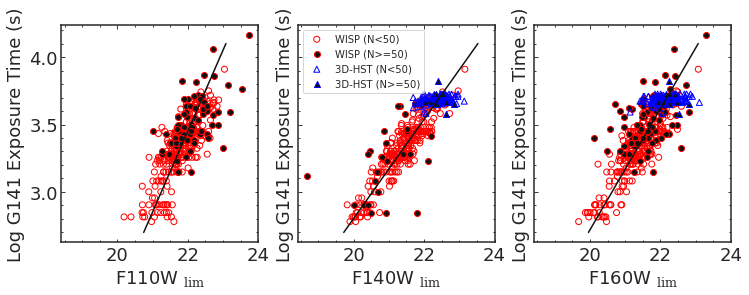

In [26]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4),  sharex=True, sharey=True)

ax[0].scatter(wispmglts['F110'][wispmglts.lF110.apply(bool)],
              np.log10(wispmglts.specexp)[wispmglts.lF110.apply(bool)], 
         facecolors='none', edgecolors='r', marker='o')
ax[0].scatter(wispmglts['F110'][~wispmglts.lF110.apply(bool)],
              np.log10(wispmglts.specexp)[~wispmglts.lF110.apply(bool)], 
        facecolors='#111111', edgecolors='r', marker='o')
ax[0].plot(wispsim.MAG_LIMITS['mag_limits_spectra']['G141']['F110'][0](np.arange(2.7, 4.2, 0.1)),
              np.arange(2.7, 4.2, 0.1),  color='#111111')



ax[1].scatter(wispmglts['F140'][wispmglts.lF140.apply(bool)],
              np.log10(wispmglts.specexp)[wispmglts.lF140.apply(bool)], 
         facecolors='none', edgecolors='r', marker='o', label='WISP (N<50)')
ax[1].scatter(wispmglts['F140'][~wispmglts.lF140.apply(bool)],
              np.log10(wispmglts.specexp)[~wispmglts.lF140.apply(bool)], 
        facecolors='#111111', edgecolors='r', marker='o', label='WISP (N>=50)')

ax[1].scatter(hst3dpmglts['F140'][hst3dpmglts.lF140.apply(bool)], \
              np.log10(hst3dpmglts.specexp)[hst3dpmglts.lF140.apply(bool)],  
              facecolors='none', edgecolors='b', marker='^', label='3D-HST (N<50)')
ax[1].scatter(hst3dpmglts['F140'][~hst3dpmglts.lF140.apply(bool)], \
              np.log10(hst3dpmglts.specexp)[~hst3dpmglts.lF140.apply(bool)],  
               facecolors='#111111', edgecolors='b', marker='^',  label='3D-HST (N>=50)')

ax[1].plot(wispsim.MAG_LIMITS['mag_limits_spectra']['G141']['F140'][0](np.arange(2.7, 4.2, 0.1)),
             np.arange(2.7, 4.2, 0.1),  color='#111111')

ax[-1].scatter(wispmglts['F160'][wispmglts.lF160.apply(bool)],
              np.log10(wispmglts.specexp)[wispmglts.lF160.apply(bool)], 
         facecolors='none', edgecolors='r', marker='o', label='WISP (N<50)')
ax[-1].scatter(wispmglts['F160'][~wispmglts.lF160.apply(bool)],
              np.log10(wispmglts.specexp)[~wispmglts.lF160.apply(bool)], 
        facecolors='#111111', edgecolors='r', marker='o', label='WISP (N>=50)')

ax[-1].scatter(hst3dpmglts['F160'][hst3dpmglts.lF160.apply(bool)], \
              np.log10(hst3dpmglts.specexp)[hst3dpmglts.lF140.apply(bool)],  
              facecolors='none', edgecolors='b', marker='^', label='3D-HST (N<50)')
ax[-1].scatter(hst3dpmglts['F160'][~hst3dpmglts.lF160.apply(bool)], \
              np.log10(hst3dpmglts.specexp)[~hst3dpmglts.lF160.apply(bool)],  
               facecolors='#111111', edgecolors='b', marker='^', label='3D-HST (N>=50)')
ax[-1].plot(wispsim.MAG_LIMITS['mag_limits_spectra']['G141']['F160'][0](np.arange(2.7, 4.2, 0.1)),
              np.arange(2.7, 4.2, 0.1),  color='#111111')
for a in ax:
    a.minorticks_on()
    a.set_ylabel('Log G141 Exposure Time (s)')
ax[1].legend(fontsize=10)

ax[0].set_xlabel(r'F110W $_{\mathrm{lim}}$')
ax[1].set_xlabel(r'F140W $_{\mathrm{lim}}$')
ax[2].set_xlabel(r'F160W $_{\mathrm{lim}}$')

plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limit_spec.pdf', 
            bbox_inches='tight', rasterized=True)

In [27]:
np.log10(800)

2.9030899869919438

In [28]:
from scipy import stats
def get_random_pointing(survey, key):
    ps=[x for x in pnts if x.survey.startswith(survey)]
    p=pnts[np.random.randint(len(ps))]
    vals=wisps.drop_nan(np.vstack(p.mags[key])[:,0])
    print (p)
    return p, vals

def get_max_value(values):
    values=wisps.drop_nan(values)
    if len(values)<1:
        return np.nan
    if np.equal.reduce(values):
        return np.nanmean(values)
    if len(values)>=1:
        kernel= stats.gaussian_kde(distr, bw_method=0.2)
        #kernel = wisps.kernel_density(values)
        height = kernel.pdf(np.linspace(20, 25, 100))
        mode_value = values[np.argmax(height)]
        print (mode_value)
        return float(mode_value)
    
def get_mag_limit(pnt, key, mags):
    #fit for less than 50
    maglt=np.nan
    survey= 'wisps'
  
    #leave 3d hst alone
    if (not pnt.name.lower().startswith('par')): 
        survey='hst3d'
        if (key=='F110'): 
            return maglt
        else:
            maglt=get_max_value(mags)
            print (pnt.imag_exptime, maglt)
            return maglt
            
    if pnt.name.lower().startswith('par'): 
        if (len(mags) < MAG_LIMITS['ncutoff']):
            magpol=MAG_LIMITS[survey][key][0]
            magsctt=MAG_LIMITS[survey][key][1]
            maglt=np.random.normal(magpol(np.log10(pnt.imag_exptime)), magsctt)
            return maglt

        #things aove 50 objects
        if (len(mags) >= MAG_LIMITS['ncutoff']): 
            maglt=get_max_value(mags)
            return maglt

812.0 22.17608226598497


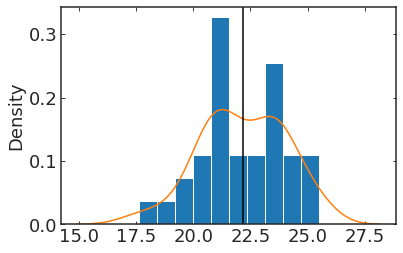

In [29]:
fig, ax=plt.subplots()
p, m=get_random_pointing('hst3d', 'F140')
plt.hist(m, density=True)
sns.kdeplot(m, ax=ax)
plt.axvline(get_mag_limit(p, 'F140', m), c='k')

In [30]:
#

In [31]:
#magpolw=wispsim.MAG_LIMITS[survey][][0]
#magpolh=wispsim.MAG_LIMITS[survey][key][0]

#magsctt=MAG_LIMITS[survey][key][1]

#maglt=np.nanmean(np.random.normal(magpol(np.log10(pnt.exposure_time)), magsctt, 100))

In [32]:
mag_lts_df['survey']=mag_lts_df['survey'].str.upper()
mag_lts_df=mag_lts_df.rename(columns={"survey": 'SURVEY'})


In [33]:
import seaborn as sns

In [34]:
wisps_pnts=[x for x in pnts if x.name.startswith('par')]

In [35]:
hst3d_pnts=[x for x in pnts if not x.name.startswith('par')]

In [36]:
pols={'wisps':{}, 'hst3d':{}}

In [37]:
#wisps.MAG_LIMITS

In [38]:
pnt_dicts={'wisps':wisps_pnts, 'hst3d':hst3d_pnts}

In [39]:
import scipy

In [40]:
def get_random_pointing(survey, key):
    pntsx=[x for x in pnts if x.survey.startswith(survey)]
    p=pntsx[np.random.randint(len(pntsx))]
    vals=wisps.drop_nan(np.vstack(p.mags[key])[:,0])
    print (p)
    return p, vals

def draw_stuff(survey='wisp', key='F140'):
    p, vals=get_random_pointing(survey, key)
    while np.isnan(vals).all():
        p, vals=get_random_pointing(survey, key)
    return p, vals

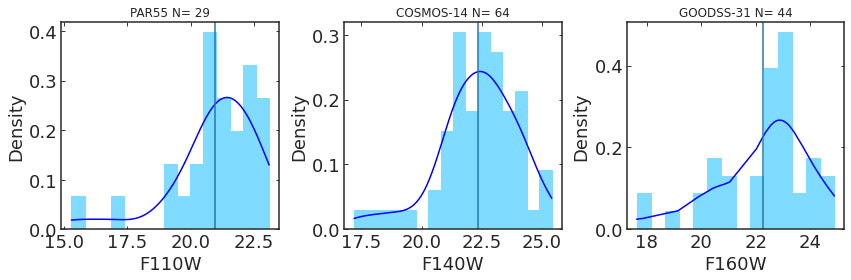

In [57]:
fig, ax=plt.subplots(figsize=(12, 4), ncols=3)

p0, vals0=draw_stuff(survey='wisp', key='F110')
vals0=wisps.drop_nan(vals0)
frq0, edges0=np.histogram(vals0, bins=int(np.ptp(vals0)/0.5), normed=True)
grid0=np.linspace(vals0.min(), vals0.max(),1000)
kde0=wisps.kernel_density(vals0).pdf(grid0)
ax[0].plot(grid0, kde0, c='b')
ax[0].bar(edges0[:-1], frq0, width=np.diff(edges0), align="edge", label='0.5 hist', color='#7FDBFF', 
        edgecolor='#7FDBFF', fill=True)
#ax[0].axvline(p0.mag_limits['F110'], c='#2ECC40', linestyle='--', label='kde')
ax[0].axvline(wispsim.get_max_value(vals0))

p1, vals1=draw_stuff(survey='hst3d', key='F140')
vals1=wisps.drop_nan(vals1)
frq1, edges1=np.histogram(vals1, bins=int(np.ptp(vals1)/0.5), normed=True)
grid1=np.linspace(vals1.min(), vals1.max(),1000)
kde1=wisps.kernel_density(vals1).pdf(grid1)
ax[1].plot(grid1, kde1, c='b')
ax[1].bar(edges1[:-1], frq1, width=np.diff(edges1), align="edge", label='0.5 hist', color='#7FDBFF', 
        edgecolor='#7FDBFF', fill=True)
#ax[1].axvline(p1.mag_limits['F140'], c='#2ECC40', linestyle='--', label='kde')
ax[1].axvline(wispsim.get_max_value(vals1))

p2, vals2=draw_stuff(survey='hst3d', key='F160')
vals2=wisps.drop_nan(vals2)
frq2, edges2=np.histogram(vals2, bins=int(np.ptp(vals2)/0.5), normed=True)
kde2=wisps.kernel_density(vals2).pdf(vals2)
ax[2].plot(vals2[np.argsort(vals2)], kde2[np.argsort(vals2)], c='b')
ax[2].bar(edges2[:-1], frq2, width=np.diff(edges2), align="edge", label='0.5 hist', color='#7FDBFF', 
        edgecolor='#7FDBFF', fill=True)
#ax[2].axvline(p2.mag_limits['F160'], c='#2ECC40', linestyle='--', label='kde')
ax[2].axvline(wispsim.get_max_value(vals2))



ax[0].set_xlabel('F110W')
ax[0].set_title(p0.name.upper()+ ' N= {}'.format(len(vals0)))

ax[1].set_xlabel('F140W')
ax[1].set_title(p1.name.upper() + ' N= {}'.format(len(vals1)))

ax[2].set_xlabel('F160W')
ax[2].set_title(p2.name.upper() + ' N= {}'.format(len(vals2)))
for a in ax:
    a.set(ylabel='Density')
    
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limit_illustration.pdf')

In [42]:
#plt.errorbar(volumes[0][0], volumes[0][0], fmt='o', mec='none')